In [2]:
import tensorflow as tf
import os
import zipfile
import random
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Rescaling

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
train_dir="/kaggle/input/teeth-dataset/Teeth_Dataset/Training"
val_dir="/kaggle/input/teeth-dataset/Teeth_Dataset/Validation"

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    label_mode='categorical',
    image_size=(256,256)
)

Found 3087 files belonging to 7 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    label_mode='categorical',
    image_size=(256,256)
)

Found 1028 files belonging to 7 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
train_labels = []
for images, labels in train_ds:
    class_indices = np.argmax(labels.numpy(), axis=1)
    train_labels.extend(class_indices)

train_labels = np.array(train_labels)

In [9]:
#calculating the weight of each class
class_counts = np.bincount(train_labels)

total_samples = len(train_labels)

class_weights = {}

for class_index in range(len(class_counts)):
    class_weight = total_samples / (len(class_counts) * class_counts[class_index])
    class_weights[class_index] = class_weight

print("Class Weights:", class_weights)

Class Weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [14]:
normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [30]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()

images = batch[0]
images.min(), images.max()

(0.0, 255.0)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

In [14]:
model_filepath = "/kaggle/working/model-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [31]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(256, 256, 3),
                                                  include_top=False,
                                                  weights='imagenet')

In [32]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [33]:
len(base_model.layers)

238

In [37]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [38]:
inputs = layers.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)  

model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 1,058,103 (4.04 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=[early_stopping, checkpoint, reduce_lr],
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3557 - loss: 1.6703
Epoch 1: val_accuracy improved from 0.31420 to 0.71790, saving model to /kaggle/working/model-01-0.7179.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.3569 - loss: 1.6676 - val_accuracy: 0.7179 - val_loss: 0.9494 - learning_rate: 3.0000e-04
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7022 - loss: 0.8802
Epoch 2: val_accuracy improved from 0.71790 to 0.80837, saving model to /kaggle/working/model-02-0.8084.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7024 - loss: 0.8796 - val_accuracy: 0.8084 - val_loss: 0.6151 - learning_rate: 3.0000e-04
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8102 - loss: 0.6011
Epoch 3: val_accuracy improved from 0.80837 to 0.86868, saving model to /kaggle/working/model-03-0.8687.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8104 - loss: 0.6006 - val_accuracy: 0.8687 - val_loss: 0.4416 - learni

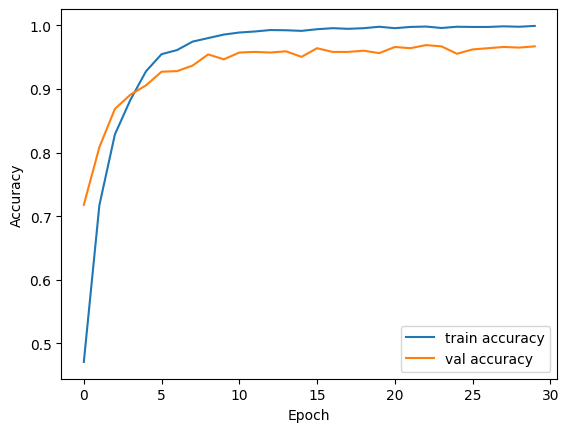

In [41]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/teeth-dataset/Teeth_Dataset/Testing",
    shuffle=False,
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

Found 1508 files belonging to 10 classes.


In [ ]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [45]:
my_model=load_model("/kaggle/working/model-21-0.9660.keras")

NotImplementedError: in user code:

    File "/tmp/ipykernel_36/1703461357.py", line 18, in None  *
        lambda x, y: filter_classes(x, y)
    File "/tmp/ipykernel_36/1703461357.py", line 11, in filter_classes  *
        for index in classes_to_remove_indices:

    NotImplementedError: break and return statements which depend on a TF condition are not supported in Python for loops. Did you intend to make it a TF loop?
    See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#consistency-of-control-flow-types for more info.


In [64]:
test_ds.class_names

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT', 'out', 'output', 'outputs']

In [51]:
my_model.evaluate(test_ds)

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 10), output.shape=(None, 7)